# SymPyで記号演算

SymPyはPythonの数学記号計算ライブラリであり、数学式の記号導出や演算を行うことができます。一部の専門的な記号演算ソフトウェアと比較すると、SymPyの機能や演算速度はまだ劣りますが、完全にPythonで書かれているため、他のPython科学計算ライブラリと組み合わせて使用することができます。例えば、この章の最後の節では、SymPyを使用して単振り子システムの微分方程式を取得し、それを自動的に数値演算プログラムに変換し、SciPyの積分モジュールを使用してその微分方程式を解く方法を紹介します。

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import helper.matplotlib
import helper.magics
from sympy import *
import sympy

sympy.__version__

'1.13.3'

## 例から始める

SymPyの構文構造や各種演算機能を詳しく説明する前に、この節ではいくつかの例を通じてSymPyで記号演算問題を解決する一般的な手順を説明します。

### 表紙の古典的な公式

以下は本書の表紙の左上隅にある数学公式です：

$$e^{\mathrm{i} \pi} + 1 = 0$$
    
この公式はオイラーの等式と呼ばれ、$e$は自然定数、$\mathrm{i}$は虚数単位、$\pi$は円周率です。これは数学の中で最も美しい公式とされ、5つの基本的な数学定数を加算、乗算、べき乗で結びつけています。以下ではSymPyを使用してこの公式を検証します。
 
まず`sympy`ライブラリからすべての名前を読み込みます。`E`は自然定数、`I`は虚数単位、`pi`は円周率を表すため、これらを使用して直接オイラーの公式の値を計算できます：

In [2]:
from sympy import *

E ** (I * pi) + 1

0

SymPyは数学公式の導出と証明も支援します。オイラーの等式は、$\pi$を以下のオイラーの公式に代入することで得られます：

$$e^{{\mathrm{i}}x}=\cos x+ {\mathrm{i}} \sin x$$
       
SymPyでは`expand()`を使用して式を展開できます。以下では$e^{{\mathrm{i}}x}$を展開してみます：

In [3]:
x = symbols("x")
expand(E ** (I * x))

exp(I*x)

残念ながら成功しませんでしたが、`expand()`のパラメータ`complex`を`True`に設定すると、式が実数部と虚数部に分かれます：

In [4]:
expand(exp(I * x), complex=True)

I*exp(-im(x))*sin(re(x)) + exp(-im(x))*cos(re(x))

今度は式が展開されましたが、結果は非常に複雑です。$\operatorname{re}{\left(\right)}$は実数値を取る関数、$\operatorname{im}{\left(\right)}$は虚数値を取る関数です。これらが現れる理由は、`expand()`が$x$を複素数として扱うためです。$x$を実数として指定するには、以下のように$x$を再定義する必要があります：

In [5]:
x = Symbol("x", real=True)
expand(exp(I * x), complex=True)

I*sin(x) + cos(x)

ようやくオイラーの公式が得られましたが、それを証明するにはどうすればよいでしょうか？テイラー多項式を使用して展開することができます：

In [6]:
tmp = series(exp(I * x), x, 0, 10)
tmp

1 + I*x - x**2/2 - I*x**3/6 + x**4/24 + I*x**5/120 - x**6/720 - I*x**7/5040 + x**8/40320 + I*x**9/362880 + O(x**10)

展開後、虚数項と実数項が交互に現れます。オイラーの公式によれば、虚数項の和は$\sin{x}$のテイラー級数に等しく、実数項の和は$\cos{x}$のテイラー展開に等しいはずです。以下で`tmp`の実部を取得します：

In [7]:
re(tmp)

x**8/40320 - x**6/720 + x**4/24 - x**2/2 + re(O(x**10)) + 1

次に$\cos{x}$をテイラー展開し、その各項が上の結果と一致することを確認します：

In [8]:
series(cos(x), x, 0, 10)

1 - x**2/2 + x**4/24 - x**6/720 + x**8/40320 + O(x**10)

次に`tmp`の虚部を取得します：

In [9]:
im(tmp)

x**9/362880 - x**7/5040 + x**5/120 - x**3/6 + x + im(O(x**10))

次に$\sin{x}$をテイラー展開し、その各項も上の結果と一致することを確認します：

In [10]:
series(sin(x), x, 0, 10)

x - x**3/6 + x**5/120 - x**7/5040 + x**9/362880 + O(x**10)

$e^{{\mathrm{i}}x}$の展開式の実部と虚部がそれぞれ$\cos{x}$と$\sin{x}$に等しいため、オイラーの公式の正しさが検証されました。

### 球体の体積

SciPyの章では、数値積分を使用して球体の体積を計算する方法を紹介しましたが、SymPyの`integrate()`は記号積分を計算できます。例えば、以下の文は`integrate()`を使用して不定積分を計算します：

In [11]:
integrate(x * sin(x), x)

-x*cos(x) + sin(x)

変数`x`の範囲を指定すると、`integrate()`は定積分を計算します：

In [12]:
integrate(x * sin(x), (x, 0, 2 * pi))

-2*pi

球体の体積を計算するために、まず円の面積を計算する方法を見てみましょう。円の半径を`r`とすると、円上の任意の点のY座標関数は次のようになります：

$$y(x) = \sqrt{r^2 - x^2}$$

関数$y(x)$を$-r$から$r$の区間で定積分することで半円の面積を得ることができます。以下のプログラムはこの定積分を計算します：まず、演算に必要な記号を定義する必要があります。`symbols()`を使用して複数の記号を一度に作成できます。半径`r`を定義する際には、`positive`パラメータを`True`に設定して、円の半径が正数であることを示します：

In [13]:
x, y = symbols("x, y")
r = symbols("r", positive=True)
circle_area = 2 * integrate(sqrt(r**2 - x**2), (x, -r, r))
circle_area

pi*r**2

次に、この面積公式を定積分することで球体の体積を得ることができますが、X軸座標が変化すると、対応する断面の半径も変化します。X軸の座標を`x`、球体の半径を`r`とすると、`x`の位置での断面の半径は前述の公式`y(x)`を使用して計算できます。したがって、`circle_area`の変数`r`を置換する必要があります：

In [14]:
circle_area = circle_area.subs(r, sqrt(r**2 - x**2))
circle_area

pi*(r**2 - x**2)

次に、`circle_area`の変数`x`を$-r$から$r$の区間で定積分し、球体の体積公式を得ます：

In [15]:
integrate(circle_area, (x, -r, r))

4*pi*r**3/3

`subs()`は式の中の記号を置換することができ、以下の3つの呼び出し方法があります：

* `expression.subs(x, y)`：式の中の`x`を`y`に置換します。
* `expression.subs({x:y,u:v})`：辞書を使用して複数回置換します。
* `expression.subs([(x,y),(u,v)])`：リストを使用して複数回置換します。

複数回の置換は順次実行されるため、`expression.sub([(x, y), (y, x)])`は記号`x`と`y`を交換することはできません。

### 数値微分

数値微分とは、関数の離散点での関数値に基づいて、ある点での導関数や高階導関数の近似値を計算する方法です。例えば、$h$がゼロに十分近い場合、以下の公式を使用して$f(x)$の$x$での導関数$f'(x)$を計算できます：

$$f'(x)\approx \frac {f(x+h)-f(x)}{h}$$

上記の公式は2つの関数値を使用して導関数値を計算するため、2点公式と呼ばれます。使用する点数が多いほど数値微分の精度が高くなります。SymPyが提供する`as_finite_diff()`を使用してN点公式を自動的に計算できます。まず、`symbols()`を使用して3つの記号オブジェクトを定義します。`f`を定義する際には、`cls`パラメータを`Function`に設定して、それが数学関数を表す記号であることを示します。

In [16]:
x = symbols("x", real=True)
h = symbols("h", positive=True)
f = symbols("f", cls=Function)

`f`は関数を表す記号であり、`f(x)`は独立変数が`x`の関数です。以下ではその`diff()`メソッドを呼び出して、`x`に関する1階導関数を計算します：

In [17]:
f_diff = f(x).diff(x, 1)
f_diff

Derivative(f(x), x)

次に、その`as_finite_difference()`メソッドを呼び出して、1階導関数を`f(x)`、`f(x-h)`、`f(x-2*h)`、`f(x-3*h)`を使用した4点公式に変換します：

In [18]:
expr_diff = f_diff.as_finite_difference([x, x - h, x - 2 * h, x - 3 * h])
expr_diff

11*f(x)/(6*h) - f(-3*h + x)/(3*h) + 3*f(-2*h + x)/(2*h) - 3*f(-h + x)/h

以下では$f(x)=x \cdot e^{-x^2}$を例として、数値微分と記号微分の誤差を比較します。まず、`subs()`メソッドを使用して`expr_diff`の`f(x)`を目的の関数に置換し、その`doit()`メソッドを呼び出して導関数を計算します：

In [19]:
sym_dexpr = f_diff.subs(f(x), x * exp(-(x**2))).doit()
sym_dexpr

-2*x**2*exp(-x**2) + exp(-x**2)

次に、`lambdify()`を呼び出して、上記の`sym_dexpr`式を数値演算の関数に変換します。最初のパラメータは独立変数のリスト、2番目のパラメータは演算式です。ここでは`modules`パラメータを"numpy"に設定しているため、`sym_dfunc()`は配列に対して演算を行うことができます：

In [20]:
sym_dfunc = lambdify([x], sym_dexpr, modules="numpy")
sym_dfunc(np.array([-1, 0, 1]))

array([-0.36787944,  1.        , -0.36787944])

`expr_diff`は加算式であるため、その`args`属性を使用してすべての加算項を取得できます：

In [21]:
print(expr_diff.args)

(-3*f(-h + x)/h, -f(-3*h + x)/(3*h), 3*f(-2*h + x)/(2*h), 11*f(x)/(6*h))


上記の加算項は独立変数の小さい順に並んでいません。以下では、ワイルドカード`w`と`c`で構成されるテンプレート`c * f(w)`を使用して各加算項をマッチングし、各項の係数と関数パラメータを抽出します：

In [22]:
w = Wild("w")
c = Wild("c")
patterns = [arg.match(c * f(w)) for arg in expr_diff.args]

各マッチング結果はワイルドカードをキーとする辞書です。例えば、以下は最初の項のマッチング結果で、この項の係数が`-3 / h`、関数`f`のパラメータが`-h + x`であることを示しています。

In [23]:
print(patterns[0])

{w_: -h + x, c_: -3/h}


以下では、ワイルドカード`w`のマッチング結果を使用してソート用のキー値を計算し、ソートされたリストから各マッチング結果のワイルドカード`c`に対応する式を選択します：

In [24]:
coefficients = [t[c] for t in sorted(patterns, key=lambda t: t[w])]
print(coefficients)

[-1/(3*h), 3/(2*h), -3/h, 11/(6*h)]


以下では、係数式のリストの`h`を`0.001`に置換して、係数配列を取得します。SymPyの浮動小数点演算はSymPyの`Float`オブジェクトを返すため、Pythonの`float`オブジェクトに変換するために`float()`を呼び出す必要があります：

In [25]:
coeff_arr = np.array([float(coeff.subs(h, 1e-3)) for coeff in coefficients])
print(coeff_arr)

[ -333.33333333  1500.         -3000.          1833.33333333]


次に、NumPyを使用して数値微分の値を計算し、`sym_dfunc()`の演算結果と比較して、最大絶対誤差を出力します：

In [26]:
def moving_window(x, size):
    from numpy.lib.stride_tricks import as_strided

    x = np.ascontiguousarray(x)
    return as_strided(
        x, shape=(x.shape[0] - size + 1, size), strides=(x.itemsize, x.itemsize)
    )


x_arr = np.arange(-2, 2, 1e-3)
y_arr = x_arr * np.exp(-x_arr * x_arr)
num_res = (moving_window(y_arr, 4) * coeff_arr).sum(axis=1)
sym_res = sym_dfunc(x_arr[3:])
print(np.max(abs(num_res - sym_res)))

4.089441674182126e-09


点数と誤差の関係を比較するために、以下の`finite_diff_coefficients()`関数で間隔`h`、点数`order`の係数を計算し、2、3、4点公式に対応する誤差曲線を描画します。結果は次のグラフに示す通りで、Y軸は対数軸であることに注意してください。

In [27]:
def finite_diff_coefficients(f_diff, order, h):
    v = f_diff.variables[0]
    points = [x - i * h for i in range(order)]
    expr_diff = f_diff.as_finite_difference(points)
    w = Wild("w")
    c = Wild("c")
    patterns = [arg.match(c * f(w)) for arg in expr_diff.args]
    coefficients = np.array([float(t[c]) for t in sorted(patterns, key=lambda t: t[w])])
    return coefficients

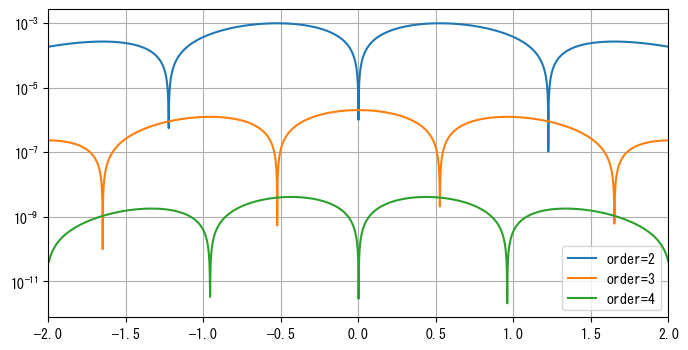

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
for order in [2, 3, 4]:
    coeff_arr = finite_diff_coefficients(f_diff, order, 0.001)

    x_arr = np.arange(-2, 2, 1e-3)
    y_arr = x_arr * np.exp(-x_arr * x_arr)
    num_res = (moving_window(y_arr, order) * coeff_arr).sum(axis=1)
    sym_res = sym_dfunc(x_arr[order - 1 :])
    error = np.abs(num_res - sym_res)
    ax.semilogy(x_arr[order - 1 :], error, label=f"order={order}")

ax.grid(True)
ax.set_xlim(-2, 2)
# print(np.max(abs(num_res - sym_res)))
ax.legend(loc="lower right");

## 数学式

このセクションでは、数学式の構造について詳しく説明します。この部分は少し退屈かもしれませんが、式の構造を理解することで、SymPyをより複雑な計算に活用することができます。

### シンボル

数学的なシンボルは`Symbol`オブジェクトで表されます。シンボルオブジェクトの`name`属性はシンボル名で、このシンボル名は式を表示する際に使用されます。`Symbol`オブジェクトのシンボル名とPythonの変数名には直接的な関係はありませんが、使いやすさのために、通常は変数名とシンボル名を同じにします。シンボルと同名の変数を素早く作成するために、`var()`を使用することができます。例えば：

In [29]:
var("x0 y0 x1 y1")

(x0, y0, x1, y1)

上記のコードは、`x0`、`y0`、`x1`、`y1`という名前の4つの`Symbol`オブジェクトを作成し、同時に現在の名前空間にこれらの`Symbol`オブジェクトを表す4つの変数を作成します。シンボルオブジェクトは文字列に変換されるときに`name`属性を直接使用するため、インタラクティブ環境で変数`x0`を表示すると、その値は`x0`となります：

In [30]:
%C type(x0); x0.name; type(x0.name)

        type(x0)          x0.name  type(x0.name)
------------------------  -------  -------------
sympy.core.symbol.Symbol  'x0'     str          


インタラクティブ環境で`var()`を使用すると、変数と`Symbol`オブジェクトを素早く作成できますが、プログラム内で使用すると混乱を招く可能性があります。その場合は、`symbols()`を使用して`Symbol`オブジェクトを作成し、それらを明示的に変数に代入することができます：

In [31]:
x1, y1 = symbols("x1 y1")
type(x1)

sympy.core.symbol.Symbol

もちろん、手間を厭わなければ、直接`Symbol`クラスを使用してオブジェクトを作成することもできます：

In [32]:
x2 = Symbol("x2")

変数名とシンボル名は異なるものでも構いません。以下では、変数`t`を使用してシンボル`x0`を表し、`alpha`と`beta`という名前のシンボルを作成し、変数`a`と`b`でそれぞれ表します。シンボルがギリシャ文字名を使用する場合、ギリシャ文字として表示されます。

In [33]:
t = x0
a, b = symbols("alpha, beta")
sin(a) + sin(b) + x0

x0 + sin(alpha) + sin(beta)

数学式のシンボルには通常、特定の仮定があります。例えば、`m, n`は通常整数であり、`z`は複素数を表すために使用されます。`var()`、`symbols()`、または`Symbol()`を使用して`Symbol`オブジェクトを作成する際に、キーワード引数を使用して作成するシンボルの仮定条件を指定できます。これらの仮定条件は、それらが関与する計算に影響を与えます。例えば、以下では2つの整数シンボル`m`と`n`、および正数シンボル`x`を作成しています：

In [34]:
m, n = symbols("m, n", integer=True)
x = Symbol("x", positive=True)

各シンボルには多くの`is_*`属性があり、シンボルのさまざまな仮定条件を判断するために使用されます。IPythonでは、オートコンプリート機能を使用してこれらの仮定の名前を素早く確認できます。アンダースコアの後に大文字が続く属性はオブジェクトのタイプを判断するために使用され、すべて小文字の属性はシンボルの仮定条件を判断するために使用されます。

In [35]:
%omit [attr for attr in dir(x) if attr.startswith("is_") and attr.lower() == attr]

['is_algebraic',
 'is_algebraic_expr',
 'is_antihermitian',
 'is_commutative',
...


以下の判断では、`x`はシンボルオブジェクトであり、正数です。なぜなら、比較が可能であり、虚数ではありません。`x`は複素数です。なぜなら、複素数は実数を含み、実数は正数を含むからです。

In [36]:
%C x.is_Symbol; x.is_positive; x.is_imaginary; x.is_complex

x.is_Symbol  x.is_positive  x.is_imaginary  x.is_complex
-----------  -------------  --------------  ------------
True         True           False           True        


`assumptions0`属性を使用すると、すべての仮定条件を素早く確認できます。`commutative`が`True`の場合、そのシンボルは交換法則を満たします。その他の仮定条件は、英語名からその意味を容易に理解できるため、ここでは詳細に説明しません。

In [37]:
%col 4 x.assumptions0

{'positive': True,                 'extended_real': True,            'finite': True,                   'nonzero': True,                 
 'extended_nonnegative': True,     'hermitian': True,                'extended_nonzero': True,         'nonnegative': True,             
 'complex': True,                  'imaginary': False,               'infinite': False,                'nonpositive': False,            
 'real': True,                     'negative': False,                'zero': False,                    'extended_nonpositive': False,   
 'extended_positive': True,        'extended_negative': False,       'commutative': True}             


SymPyでは、すべてのオブジェクトが`Basic`クラスから継承されています。実際、これらの`is_*`属性と`assumptions0`属性は`Basic`クラスで定義されています：

In [38]:
Symbol.mro()

[sympy.core.symbol.Symbol,
 sympy.core.expr.AtomicExpr,
 sympy.core.basic.Atom,
 sympy.core.expr.Expr,
 sympy.logic.boolalg.Boolean,
 sympy.core.basic.Basic,
 sympy.printing.defaults.Printable,
 sympy.core.evalf.EvalfMixin,
 object]

### 数値

シンボリック計算を実現するために、SymPy内部には数値計算システムが一通り用意されています。そのため、SymPyの数値はPythonの整数や浮動小数点数とは完全に異なるオブジェクトです。使いやすさのために、SymPyはPythonの数値型を自動的にSymPyの数値型に変換しようとします。SymPyは、Pythonの数値をSymPyの数値に素早く変換するために`S`オブジェクトを提供しています。以下の例では、SymPyの数値が計算に含まれる場合、結果もSymPyの数値オブジェクトとなります：

In [39]:
%C 1/2 + 1/3; S(1)/2 + 1/S(3)

    1/2 + 1/3       S(1)/2 + 1/S(3)
------------------  ---------------
0.8333333333333333  5/6            


`5/6`は`Rational`オブジェクトで、2つの整数の商として表されます。数学的には有理数と呼ばれます。`Rational`を直接使用して作成することもできます：

In [40]:
print(type(S(5) / 6))
Rational(5, 10)  # 有理数は自動的に約分されます

<class 'sympy.core.numbers.Rational'>


1/2

実数は`Float`オブジェクトで表され、標準の浮動小数点数と似ていますが、その精度（有効数字）はパラメータで指定できます。浮動小数点数や`Float`オブジェクトは内部で2進数を使用して数値を表すため、10進数の正確な小数を正確に表すことができない場合があります。`N()`を使用して浮動小数点数の実際の数値を確認できます。例えば、以下のコードは浮動小数点数`0.1`と`10000.1`の60桁の有効数字を表示します。数値の絶対精度は数値が大きくなるにつれて減少することがわかります：

In [41]:
print(N(0.1, 60))
print(N(10000.1, 60))

0.100000000000000005551115123125782702118158340454101562500000
10000.1000000000003637978807091712951660156250000000000000000


浮動小数点数の精度は限られているため、`Float`オブジェクトを作成する際に精度パラメータを指定しても、理想値との誤差を縮めることはできません。その場合は、文字列を使用して数値を表すことができます：

In [42]:
print(
    N(Float(0.1, 60), 60)
)  # 浮動小数点数でRealオブジェクトを作成する場合、精度は浮動小数点数と同じです
print(
    N(Float("0.1", 60), 60)
)  # 文字列でRealオブジェクトを作成する場合、指定された精度が有効です
print(N(Float("0.1", 60), 65))  # 表示精度を上げると、完全に正確でないことがわかります

0.100000000000000005551115123125782702118158340454101562500000
0.100000000000000000000000000000000000000000000000000000000000
0.099999999999999999999999999999999999999999999999999999999999996111


`N()`は、数値式を指定された精度で`Float`オブジェクトに変換することができます。以下は、$\pi$と$\sqrt{2}$の50桁の精度の浮動小数点数値を計算します：

In [43]:
print(N(pi, 50))
print(N(sqrt(2), 50))

3.1415926535897932384626433832795028841971693993751
1.4142135623730950488016887242096980785696718753769


### 演算子と関数

SymPyはすべての数学演算子と数学関数を再定義しています。例えば、`Add`クラスは加算を表し、`Mul`クラスは乗算を表し、`Pow`クラスは指数演算を表し、`sin`クラスは正弦関数を表します。`Symbol`オブジェクトと同様に、これらの演算子と関数はすべて`Basic`クラスから継承されています。IPythonでこれらの継承リストを確認してください。例えば、`Add.mro()`です。これらのクラスを使用して複雑な式を作成することができます：

In [44]:
var("x y z n")
Add(x, y, z)

x + y + z

In [45]:
Add(Mul(x, y, z), Pow(x, y), sin(z))

x*y*z + x**y + sin(z)

`Basic`クラスでは`__add__()`などの演算子に関連するマジックメソッドが再定義されているため、Pythonの式と同じ方法でSymPyの式を作成することができます：

In [46]:
x * y * z + x**y + sin(z)

x*y*z + x**y + sin(z)

`Basic`クラスには2つの重要な属性があります：`func`と`args`です。`func`属性はオブジェクトのクラスを取得し、`args`はその引数を取得します。これらの属性を使用して、SymPyが作成した式を観察することができます。減算演算のクラスがないことに驚かれるかもしれませんが、以下の例で減算演算の式を見てみましょう：

In [47]:
t = x - y
%C t.func; t.args; t.args[1].func; t.args[1].args

      t.func         t.args    t.args[1].func    t.args[1].args
------------------  -------  ------------------  --------------
sympy.core.add.Add  (x, -y)  sympy.core.mul.Mul  (-1, y)       


上記の例からわかるように、式`x - y`はSymPyでは`Add(x, Mul(-1, y))`として表されます。同様に、SymPyには除算クラスはありません。上記と同じ方法で`x / y`がSymPyでどのように表されるかを観察してください。

SymPyの式は、実際には`Basic`クラスのさまざまなオブジェクトが多重にネストされたツリー構造です。`dotprint()`を使用すると、式をGraphvizのDOT言語で記述されたグラフに変換できます。本書で提供されている`%dot`コマンドを使用すると、Notebookに表示することができます。次のグラフは、式$x y \frac{\sqrt{x^{2} - y^{2}}}{x + y}$の構造を示しています：

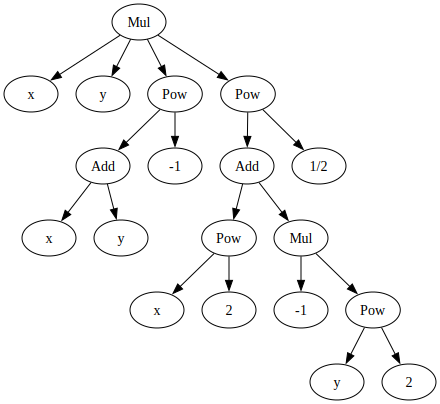

In [48]:
from sympy.printing.dot import dotprint

graph = dotprint(x * y * sqrt(x**2 - y**2) / (x + y))

import graphviz

graphviz.Source(graph, format="svg")

`Basic`オブジェクトの`args`属性のタイプはタプルであるため、式が作成されると変更できません。不変の構造を使用して式を表すことには多くの利点があります。例えば、式を辞書のキーとして使用することができます。

SymPyで事前に定義された特別な演算意味を持つ数学関数を使用するだけでなく、`Function()`を使用してカスタムの数学関数シンボルを作成することもできます：

In [49]:
f = Function("f")

`Function`はクラスですが、上記のコードで得られる`f`は`Function`クラスのインスタンスではありません。事前定義された数学関数と同様に、`f`はクラスであり、`Function`クラスから継承されています：

In [50]:
issubclass(f, Function)

True

`f`を使用して式を作成すると、そのインスタンスが作成されます：

In [51]:
t = f(x, y)
%C type(t); t.func; t.args

type(t)  t.func  t.args
-------  ------  ------
f        f       (x, y)


`f`のインスタンス`t`は式の演算に参加できます：

In [52]:
t + t * t

f(x, y)**2 + f(x, y)

`symbols()`と`var()`を使用する際に、`cls`パラメータを`Function`に設定して関数シンボルを作成することができます：

In [53]:
g, h = symbols("g h", cls=Function)
g(x, y) + h(y) ** 2

g(x, y) + h(y)**2

演算子と関数は通常自動的に評価されます。式を作成する際に`evaluate`パラメータを`False`に設定すると、自動的に評価されません。例えば、`x + 2*x`を直接計算すると`3*x`が得られますが、`Add`を使用して加算式を作成し、`evaluate`パラメータを`False`に設定すると、式は簡略化されません。

In [54]:
Add(x, 2 * x, evaluate=False)

x + 2*x

一部の数学式はデフォルトで評価されません。例えば、`Integral`は積分式を表し、積分を計算するのではなく、積分記号を使用して式を表示します：

In [55]:
Integral(sin(x))

Integral(sin(x), x)

シンボリック積分を計算するには、積分演算を行う関数`integrate()`を使用するか、積分式の`doit()`メソッドを呼び出します：

In [56]:
from IPython.display import display_latex

display_latex(integrate(sin(x), x))
display_latex(Integral(sin(x), x).doit())

SymPyが積分演算を実行できない場合、`integrate()`は積分式を返します。例えば：

In [57]:
integrate(x**x, x)

Integral(x**x, x)

SymPyには多くの演算に対応する演算関数と式があります。例えば、`diff()`は微分演算を行う関数であり、`Derivative`は微分式です。`laplace_transform()`はラプラス変換を行う関数であり、`LaplaceTransform`はラプラス変換式です。

### ワイルドカード

ワイルドカードを使用すると、特定の式にマッチするテンプレートを作成できます。例えば、以下の例では、`a`と`b`は`Wild`ワイルドカードオブジェクトであり、`a * b ** 2`はこれらのワイルドカードを使用して作成された式テンプレートです。式オブジェクトの`match()`メソッドを呼び出して、指定されたテンプレートを使用して式をマッチさせることができます。これは、ワイルドカードをキーとし、そのワイルドカードにマッチするサブ式を値とする辞書を返します。

:::{tip}
SymPyが提供する`init_printing()`を実行すると、数学記号を使用して演算結果を表示できます。ただし、Pythonの組み込みオブジェクトもLaTeX表示に変換されます。本書では、組み込みオブジェクトを通常のテキストで表示し、本書で提供されている`%latex`マジックメソッドを使用して組み込みオブジェクトをLaTeXに変換します。
:::

In [58]:
x, y = symbols("x, y")
a = Wild("a")
b = Wild("b")
%latex (3 * x * (x + y)**2).match(a * b**2)

`find()`メソッドは、式のツリー構造内でテンプレートにマッチするすべてのサブツリーを検索します。以下は、$(x + y)^3$の展開式でテンプレートにマッチするすべてのサブ式を検索します：

In [59]:
expr = expand((x + y) ** 3)
%latex expr
%latex expr.find(a * b**2)

整数2がテンプレートにマッチするのは意外です。以下の`find_match()`を使用して、すべてのサブ式とテンプレートのマッチ結果を出力します。次の表に示すように：

In [60]:
from helper.html import latex_table

def find_match(expr, pattern):
    return [e.match(pattern) for e in expr.find(pattern)]


def display_match_table(expr, pattern):
    sub_exprs = expr.find(pattern)
    rows = [
        (f"{latex(sub_expr)}", f"{latex(sub_expr.match(pattern))}")
        for sub_expr in sub_exprs
    ]
    columns = ["式", "マッチ結果"]
    return latex_table(rows, columns, columns)

find_match(expr, a * b**2)
display_match_table(expr, a * b**2)

式,マッチ結果
\[2\],"\[\left\{ a : 1, \ b : \sqrt{2}\right\}\]"
\[3\],"\[\left\{ a : 1, \ b : \sqrt{3}\right\}\]"
\[3 x y^{2}\],"\[\left\{ a : 3 x, \ b : y\right\}\]"
\[3 x^{2} y\],"\[\left\{ a : 3 y, \ b : x\right\}\]"
\[x\],"\[\left\{ a : 1, \ b : \sqrt{x}\right\}\]"
\[y^{2}\],"\[\left\{ a : 1, \ b : y\right\}\]"
\[x^{3} + 3 x^{2} y + 3 x y^{2} + y^{3}\],"\[\left\{ a : 1, \ b : \sqrt{x^{3} + 3 x^{2} y + 3 x y^{2} + y^{3}}\right\}\]"
\[x^{3}\],"\[\left\{ a : 1, \ b : x^{\frac{3}{2}}\right\}\]"
\[x^{2}\],"\[\left\{ a : 1, \ b : x\right\}\]"
\[y\],"\[\left\{ a : 1, \ b : \sqrt{y}\right\}\]"


上記の結果から、テンプレートと式のマッチングプロセスでSymPyは式を変換し、数学的に正しいマッチング結果を見つけることがわかります。これらの式変換によって得られた結果を除外するために、ワイルドカードを定義する際に`exclude`パラメータを使用して、マッチできないオブジェクトのリストを指定できます。ワイルドカードにマッチする式にこのパラメータ内のオブジェクトが含まれている場合、マッチングは失敗します。以下のワイルドカード`a`と`b`はどちらも整数1を含むことができず、`b`は指数演算を含むことができません。SymPyでは平方根は指数式で表されることに注意してください。次の表を参照してください。

In [61]:
a = Wild("a", exclude=[1])
b = Wild("b", exclude=[1, Pow])

find_match(expr, a * b**2)
display_match_table(expr, a * b**2)

式,マッチ結果
\[3 x y^{2}\],"\[\left\{ a : 3 x, \ b : y\right\}\]"
\[3 x^{2} y\],"\[\left\{ a : 3 y, \ b : x\right\}\]"
\[y^{3}\],"\[\left\{ a : y, \ b : y\right\}\]"
\[x^{3}\],"\[\left\{ a : x, \ b : x\right\}\]"


`replace()`メソッドを使用して、式内の部分式を置換することができます。例えば、以下のように`a * b**2`にマッチするすべての部分式を`(a + b)**2`に置換します：

In [62]:
expr.replace(a * b**2, (a + b) ** 2)

4*x**2 + 4*y**2 + (x + 3*y)**2 + (3*x + y)**2

`WildFunction`を使用すると、任意の関数にマッチするワイルドカードを定義できます。以下の例では、`f`は`exp`、`sin`、`abs`の3つの関数にマッチし、そのマッチ結果には関数の引数が含まれます。指数演算は演算子として扱われ、`sqrt`は実際には指数演算で表されるため、これらは`f`にマッチしません。詳細は次の表を参照してください：

In [63]:
f = WildFunction("f")
x = symbols("x", real=True)
expr = sqrt(x) / sin(y**2) + abs(exp(x) * x)

find_match(expr, f)
display_match_table(expr, f)

式,マッチ結果
\[\sin{\left(y^{2} \right)}\],\[\left\{ \operatorname{WildFunction}{\left(f \right)} : \sin{\left(y^{2} \right)}\right\}\]
\[e^{x}\],\[\left\{ \operatorname{WildFunction}{\left(f \right)} : e^{x}\right\}\]
\[\left|{x}\right|\],\[\left\{ \operatorname{WildFunction}{\left(f \right)} : \left|{x}\right|\right\}\]


## 記号計算

SymPyが提供する記号計算機能は非常に豊富です。本節では、SymPyの一般的な記号計算機能の一部を簡単に紹介します。

### 式の変換と簡略化

`simplify()`は数学的な式を簡略化します。例えば：

In [64]:
simplify((x + 2) ** 2 - (x + 1) ** 2)

2*x + 3

`simplify()`はSymPy内部の複数の式変換関数を呼び出して式を簡略化します。しかし、数学的な式の簡略化は非常に複雑な作業であり、同じ式でも使用目的に応じて複数の簡略化方法が存在します。本節では、SymPyが提供する様々な式変換関数を紹介し、これらの関数を活用して式の変換と簡略化を行う方法を説明します。

`radsimp()`は式の分母を有理化し、結果の分母部分に無理数が含まれないようにします。例えば：

In [65]:
radsimp(1 / (sqrt(5) + 2 * sqrt(2)))

(-sqrt(5) + 2*sqrt(2))/3

シンボルを含む式も処理できます：

In [66]:
radsimp(1 / (y * sqrt(x) + x * sqrt(y)))

(-sqrt(x)*y + x*sqrt(y))/(x*y*(x - y))

`sqrtdenest()`はネストされた根号を簡略化するために使用されます。例えば：

In [67]:
expr = sqrt(2 * sqrt(6) + 5)
%latex expr, sqrtdenest(expr)

`ratsimp()`は式の分母を通分し、式を分子を分母で割った形式に変換します：

In [68]:
ratsimp(x / (x + y) + y / (x - y))

2*y**2/(x**2 - y**2) + 1

`fraction()`は式の分子と分母を含むタプルを返します。これを使用して`ratsimp()`で通分された後の分子または分母を取得できます：

In [69]:
%latex fraction(ratsimp(1 / x + 1 / y))

`fraction()`は自動的に式を通分しないため、以下のようになります：

In [70]:
%latex fraction(1 / x + 1 / y)

`cancel()`は分数式の分子と分母を約分し、それらの共通因数を取り除きます：

In [71]:
cancel((x**2 - 1) / (1 + x))

x - 1

`apart()`は式を部分分数分解します。これにより、有理関数を分子と分母の次数が小さい複数の有理関数に分解します。以下の例では、多項式分数を2つの次数が小さい分数の和に分解します：

In [72]:
s = symbols("s")
trans_func = 1 / (s**3 + s**2 + s + 1)
apart(trans_func)

-(s - 1)/(2*(s**2 + 1)) + 1/(2*(s + 1))

`trigsimp()`は式の中の三角関数を簡略化します。`method`パラメータを使用して簡略化アルゴリズムを選択できます：

In [73]:
trigsimp(sin(x) ** 2 + 2 * sin(x) * cos(x) + cos(x) ** 2)

sin(2*x) + 1

`expand_trig()`は三角関数の式を展開します：

In [74]:
expand_trig(sin(2 * x + y))

(2*cos(x)**2 - 1)*sin(y) + 2*sin(x)*cos(x)*cos(y)

`expand()`はフラグパラメータに基づいて式を展開します。デフォルトでは、次の表のフラグパラメータは`True`です：

In [75]:
flags = ["mul", "log", "multinomial", "power_base", "power_exp"]
x, y, z = symbols("x y z")
expressions = [x * (y + z), log(x * y**2), (x + y) ** 3, (x * y) ** z, x ** (y + z)]
infos = [
    "乗算の展開",
    "対数関数の引数内の積とべき乗の展開",
    "加減算式の整数べき乗の展開",
    "べき関数の底の積の展開",
    "べき関数の指数和の展開",
]
table = []
for flag, expression, info in zip(flags, expressions, infos):
    table.append(
        [f"{flag}", f"expand({expression})", f"{latex(expand(expression))}", info]
    )

latex_table(table, ["フラグ", "式", "結果", "説明"], "結果")

フラグ,式,結果,説明
mul,expand(x*(y + z)),\[x y + x z\],乗算の展開
log,expand(log(x*y**2)),\[\log{\left(x y^{2} \right)}\],対数関数の引数内の積とべき乗の展開
multinomial,expand((x + y)**3),\[x^{3} + 3 x^{2} y + 3 x y^{2} + y^{3}\],加減算式の整数べき乗の展開
power_base,expand((x*y)**z),\[\left(x y\right)^{z}\],べき関数の底の積の展開
power_exp,expand(x**(y + z)),\[x^{y + z}\],べき関数の指数和の展開


デフォルトで`True`のフラグパラメータを`False`に設定することで、対応する式を展開しないようにできます。以下の例では、`mul`を`False`に設定しているため、乗算を展開しません：

In [76]:
x, y, z = symbols("x,y,z", positive=True)
expand(x * log(y * z), mul=False)

x*(log(y) + log(z))

次の表のフラグパラメータはデフォルトで`False`です：

In [77]:
flags = ["complex", "func", "trig"]
expressions = [x * y, gamma(1 + x), sin(x + y)]
infos = ["複素数の展開", "特殊関数の展開", "三角関数の展開"]
table = []
for flag, expression, info in zip(flags, expressions, infos):
    table.append(
        [f"{flag}", f"expand({expression})", f"{latex(expand(expression))}", info]
    )
latex_table(table, ["フラグ", "式", "結果", "説明"], "結果")

フラグ,式,結果,説明
complex,expand(x*y),\[x y\],複素数の展開
func,expand(gamma(x + 1)),\[\Gamma\left(x + 1\right)\],特殊関数の展開
trig,expand(sin(x + y)),\[\sin{\left(x + y \right)}\],三角関数の展開


* `complex`：複素数の実部と虚部を展開します。

In [89]:
x, y = symbols("x,y", complex=True)
expand(x * y, complex=True)

re(x)*re(y) + I*re(x)*im(y) + I*re(y)*im(x) - im(x)*im(y)

* `func`：特殊関数を展開します。

In [90]:
expand(gamma(1 + x), func=True)

x*gamma(x)

* `trig`：三角関数を展開します。

In [91]:
expand(sin(x + y), trig=True)

sin(x)*cos(y) + sin(y)*cos(x)

`expand_log()`、`expand_mul()`、`expand_complex()`、`expand_trig()`、`expand_func()`などの関数は、対応するフラグパラメータを`True`に設定することで`expand()`をラップします。

`factor()`は多項式を因数分解できます：

In [92]:
factor(15 * x**2 + 2 * y - 3 * x - 10 * x * y)

(3*x - 2*y)*(5*x - 1)

`collect()`は指定されたシンボルの有理指数べき乗の係数を収集します。以下の例では、式`eq`中の`x`の各べき乗の係数を取得します。まず、式を展開して一連の乗算の和を得てから、`collect()`を呼び出して`x`の各べき乗の係数を収集します：

In [93]:
eq = (1 + a * x) ** 3 + (1 + b * x) ** 2
eq2 = expand(eq)
collect(eq2, x)

x**3*a_**3 + x**2*(3*a_**2 + b_**2) + x*(3*a_ + 2*b_) + 2

デフォルトのパラメータでは、`collect()`は整理された式を返します。`x`の各べき乗の係数を取得したい場合は、パラメータ`evaluate`を`False`に設定して、`x`のべき乗をキーとし、係数を値とする辞書を返すようにします。

In [94]:
p = collect(eq2, x, evaluate=False)
p

{x**2: 3*a_**2 + b_**2, x**3: a_**3, x: 3*a_ + 2*b_, 1: 2}

`coeff()`メソッドを使用して係数を取得することもできます。以下の例では、定数項と$x^2$の係数を取得します：

In [95]:
%latex eq2.coeff(x, 0), eq2.coeff(x, 2)

`collect()`は式の各べき乗の係数を収集することもできます。以下のプログラムは、式$\sin 2x$の係数を収集します：

In [96]:
collect(a * sin(2 * x) + b * sin(2 * x), sin(2 * x))

(a_ + b_)*sin(2*x)

### 方程式

SymPyでは、式は直接的に値が0の方程式を表すことができます。また、`Eq()`を使用して方程式を作成することもできます。`solve()`は方程式をシンボリックに解くことができます。最初のパラメータは方程式を表す式で、その後のパラメータは方程式中の未知の変数を表すシンボルです。以下の例では、`solve()`を使用して二次方程式を解きます：

In [97]:
a, b, c = symbols("a,b,c")
%latex solve(a * x ** 2 + b * x + c, x)

方程式の解が複数ある場合、`solve()`はすべての解を含むリストを返します。複数の式を含むリストを渡すことで、`solve()`に連立方程式を解かせることができます。得られる解は二重にネストされたリストで、各タプルが連立方程式の一組の解を表します：

In [98]:
%latex solve((x ** 2 + x * y + 1, y ** 2 + x * y + 2), x, y)

`roots()`は単変数多項式の根を計算できます：

In [99]:
%latex roots(x**3 - 3*x**2 + x + 1)

### 微分

`Derivative`は導関数を表すクラスです。最初のパラメータは微分する式で、2番目のパラメータは微分する変数です。`Derivative`は導関数を表すだけで、実際に微分を計算しません：

In [100]:
t = Derivative(sin(x), x)
t

Derivative(sin(x), x)

`doit()`メソッドを呼び出すことで微分の結果を計算できます：

In [101]:
t.doit()

cos(x)

`diff()`関数または式の`diff()`メソッドを使用して直接導関数を計算することもできます：

In [140]:
diff(sin(2 * x), x)

2*cos(2*x)

`Derivative`オブジェクトを使用して、カスタムの数学関数の導関数を表すことができます。例えば：

In [141]:
f = Function("f")
Derivative(f(x), x)

Derivative(f(x), x)

SymPyはカスタムの数学関数を微分する方法を知らないため、`diff()`は`Derivative`オブジェクトを返します。追加の変数シンボルパラメータを指定することで、高階導関数を表すことができます。例えば：

In [142]:
Derivative(f(x), x, x, x)  # またはDerivative(f(x), x, 3)

Derivative(f(x), (x, 3))

異なる変数シンボルに対して偏微分を計算することもできます：

In [143]:
Derivative(f(x, y), x, 2, y, 3)

Derivative(f(x, y), (x, 2), (y, 3))

`diff()`のパラメータは`Derivative`と同じです。以下のプログラムは、関数$\sin\left(x y\right)$を$x$で2回、$y$で3回微分した結果を計算します：

In [144]:
diff(sin(x * y), x, 2, y, 3)

x*(x**2*y**2*cos(x*y) + 6*x*y*sin(x*y) - 6*cos(x*y))

### 微分方程式

`dsolve()`は微分方程式をシンボリックに解くことができます。最初のパラメータは未知の関数を含む式で、2番目のパラメータは解くべき未知の関数です。例えば、以下のプログラムは微分方程式${f}^{'}\left(x\right) - {f}\left(x\right)=0$を解きます。得られる結果は自然指数関数で、未定係数$C_{1}$を持ちます。

In [145]:
x = symbols("x")
f = symbols("f", cls=Function)
dsolve(Derivative(f(x), x) - f(x), f(x))

Eq(f(x), C1*exp(x))

異なる形式の微分方程式は異なる解法を必要とします。`classify_ode()`を使用して、指定された微分方程式に対応する解法のリストを確認できます。以下の例では、方程式$f^{'}(x) + f(x) = (\cos(x)- \sin(x)) \, f(x)^2$に対応する解法を確認します：

In [146]:
eq = Eq(f(x).diff(x) + f(x), (cos(x) - sin(x)) * f(x) ** 2)
classify_ode(eq, f(x))

('factorable',
 'Bernoulli',
 '1st_power_series',
 'lie_group',
 'Bernoulli_Integral')

`dsolve()`の`hint`パラメータを使用して解法を指定できます。デフォルト値は`'default'`で、`classify_ode()`の戻り値の最初の解法を使用します：

In [147]:
sol1 = dsolve(eq, f(x))
sol1

Eq(f(x), 1/(C1*exp(x) - sin(x)))

`dsolve()`は`Equality`オブジェクトを返し、その`rhs`属性を使用して等号の右側の式を取得できます：

In [148]:
sol1.rhs

1/(C1*exp(x) - sin(x))

以下の例では、`'1st_power_series'`解法を使用して、解関数のテイラー展開の最初の4項を取得します。項数はパラメータ`n`で指定します。ここでは、`collect()`と`simplify()`を使用して`dsolve()`が返す式を簡略化します：

In [149]:
sol2 = dsolve(eq, f(x), hint="1st_power_series", n=4)
collect(simplify(sol2.rhs), x)

x*(C1**2 - C1) + x**2*(C1**3 - 2*C1**2 + C1/2) + x**3*(C1**4 - 3*C1**3 + 11*C1**2/6 - C1/6) + C1 + O(x**4)

以下の例では、`series()`メソッドを使用して`sol1`のテイラー展開を取得します。上記の結果と一致していることがわかりますが、2つの結果の未定係数$C_1$が互いに逆数になっています。

In [150]:
sol1.rhs.series(x, n=4)

1/C1 + x*(-1 + 1/C1)/C1 + x**2*((1 - 1/C1)**2 - 1/2)/C1 + x**3*(-(1 - 1/C1)**3 + 5/6 - 7/(6*C1))/C1 + O(x**4)

`hint`を`'all'`に設定することで、`dsolve()`に`classify_ode()`が返すすべての解法を試させることができます：

In [151]:
dsolve(eq, f(x), hint="all", n=3)

{'Bernoulli_Integral': Eq(f(x), 1/(C1*exp(x) - sqrt(2)*sin(x + pi/4)/2 + sqrt(2)*cos(x + pi/4)/2)),
 'Bernoulli': Eq(f(x), 1/(C1*exp(x) - sin(x))),
 'lie_group': Eq(f(x), 1/(C1*exp(x) - sin(x))),
 '1st_power_series': Eq(f(x), C1 + C1*x*(C1 - 1) + C1*x**2*(-C1 + (C1 - 1)*(2*C1 - 1))/2 + O(x**3)),
 'factorable': Eq(f(x), 1/(C1*exp(x) - sin(x))),
 'best': Eq(f(x), 1/(C1*exp(x) - sqrt(2)*sin(x + pi/4)/2 + sqrt(2)*cos(x + pi/4)/2)),
 'best_hint': 'Bernoulli_Integral',
 'default': 'factorable',
 'order': 1}

`sympy.ode.allhints`を使用して、システムがサポートするすべての解法を確認できます：

In [152]:
from sympy.solvers.ode import allhints

%omit allhints

('factorable',
 'nth_algebraic',
 'separable',
 '1st_exact',
...


### 積分

`integrate()`は定積分と不定積分を計算できます：

* `integrate(f, x)`：不定積分$\int f dx$ を計算します

* `integrate(f, (x, a, b))`：定積分$\int_{a}^{b} f dx$ を計算します

複数の変数に対して多重積分を計算する場合は、積分する変数を順に列挙するだけです：

* `integrate(f, x, y)`：二重不定積分$\int\int f dx dy$ を計算します

* `integrate(f, (x, a, b), (y, c, d))`：二重定積分$\int_{c}^{d}\int_{a}^{b} f dx dy$ を計算します

`Derivative`オブジェクトが微分式を表すのと同様に、`Integral`オブジェクトは積分式を表します。そのパラメータは`integrate()`と同様です。例えば：

In [153]:
e = Integral(x * sin(x), x)
e

Integral(x*sin(x), x)

積分オブジェクトの`doit()`メソッドを呼び出すことで積分を計算できます：

In [154]:
e.doit()

-x*cos(x) + sin(x)

一部の積分式はシンボリックに簡略化できません。その場合、評価メソッド`evalf()`または評価関数`N()`を呼び出して数値積分を行うことができます：

In [155]:
e2 = Integral(sin(x) / x, (x, 0, 1))
e2.doit()

Si(1)

`doit()`は特殊関数で表された値を返します。以下の例では、`evalf()`を使用してその数値を計算します：

In [156]:
print(e2.evalf())
print(e2.evalf(100))  # 精度を指定できます

0.946083070367183
0.9460830703671830149413533138231796578123379547381117904714547735666870365407979180887021330817407112


$\frac{\sin\left(x\right)}{x}$の積分は特殊関数として定義されており、0から無限大までの定積分の値は$\pi/2$です。つまり：

$$\int_{0}^{\infty} \frac{\sin\left(x\right)}{x} dx = \pi/2$$

しかし、SymPyの数値計算機能はまだ十分に強力ではなく、このような定積分に対応できません：

In [157]:
e3 = Integral(sin(x) / x, (x, 0, oo))
e3.evalf()

-0.e+0

`doit()`を呼び出すことで、正確なシンボリックな結果を計算できます：

In [158]:
e3.doit()

pi/2